In [1]:
import os
import json
from tqdm import tqdm
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
from textblob import TextBlob
import re
import math
import spacy
import datetime
import copy
from sklearn import preprocessing
import numpy as np
%matplotlib inline

In [2]:
nlp = spacy.load("en")

In [3]:
#Path to stopwords file
stopwords_repo = ""
my_stop_words = open(stopwords_repo).readlines()
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

# Data extraction

In [4]:
#Path to Pheme dataset
path = ""

In [5]:
topics = next(os.walk(path))[1]
tweets = {}
sourceTweets = {}
try:
    for topic in tqdm(topics):
        tweets[topic] = {"rumour":{}, "nonRumour":{}}
        sourceTweets[topic] = {"rumour":[], "nonRumour":[]}
        for tweetCode in os.listdir(path+topic+"/rumours/"):
            tweets[topic]["rumour"][tweetCode] = {"source":[] , "reactions":[]}
            for tweet in os.listdir(path+topic+"/rumours/"+tweetCode+"/source-tweet"):
                tweets[topic]["rumour"][tweetCode]["source"] = json.load(open(path+topic+"/rumours/"+tweetCode+"/source-tweet/"+tweet,"rb"))
                sourceTweets[topic]["rumour"].append(json.load(open(path+topic+"/rumours/"+tweetCode+"/source-tweet/"+tweet,"rb")))
            for tweet in os.listdir(path+topic+"/rumours/"+tweetCode+"/reactions"):
                tweets[topic]["rumour"][tweetCode]["reactions"].append(json.load(open(path+topic+"/rumours/"+tweetCode+"/reactions/"+tweet,"rb")))
        for tweetCode in os.listdir(path+topic+"/non-rumours/"):
            tweets[topic]["nonRumour"][tweetCode] = {"source":[] , "reactions":[]}
            for tweet in os.listdir(path+topic+"/non-rumours/"+tweetCode+"/source-tweet"):
                tweets[topic]["nonRumour"][tweetCode]["source"] = json.load(open(path+topic+"/non-rumours/"+tweetCode+"/source-tweet/"+tweet,"rb"))
                sourceTweets[topic]["nonRumour"].append(json.load(open(path+topic+"/non-rumours/"+tweetCode+"/source-tweet/"+tweet,"rb")))
            for tweet in os.listdir(path+topic+"/non-rumours/"+tweetCode+"/reactions"):
                tweets[topic]["nonRumour"][tweetCode]["reactions"].append(json.load(open(path+topic+"/non-rumours/"+tweetCode+"/reactions/"+tweet,"rb")))
except:
    print("!")

100%|████████████████████████████████████████████| 5/5 [02:12<00:00, 26.40s/it]


In [ ]:
print(f"charliehebdo => rumours : {len(sourceTweets["charliehebdo"]["rumour"])}    non-rumours : {len(sourceTweets["charliehebdo"]["nonRumour"])}") 
print(f"ferguson => rumours : {len(sourceTweets["ferguson"]["rumour"])}    non-rumours : {len(sourceTweets["ferguson"]["nonRumour"])}") 
print(f"germanwings-crash => rumours : {len(sourceTweets["germanwings-crash"]["rumour"])}    non-rumours : {len(sourceTweets["germanwings-crash"]["nonRumour"])}") 
print(f"ottawashooting => rumours : {len(sourceTweets["ottawashooting"]["rumour"])}    non-rumours : {len(sourceTweets["ottawashooting"]["nonRumour"])}") 
print(f"sydneysiege => rumours : {len(sourceTweets["sydneysiege"]["rumour"])}    non-rumours : {len(sourceTweets["sydneysiege"]["nonRumour"])}") 

In [6]:
sourceTweets_POS = copy.deepcopy(sourceTweets)
sourceTweets_NER = copy.deepcopy(sourceTweets)

In [7]:
for topic in tqdm(sourceTweets):
    for category in sourceTweets[topic]:
        for index, tweet in enumerate(sourceTweets[topic][category]):
            sent = nlp(tweet["text"])
            sourceTweets_POS[topic][category][index]["text"] = " ".join([x.pos_ for x in sent if x.pos_ != ''])
            sourceTweets_NER[topic][category][index]["text"] = " ".join([x.ent_type_ for x in sent if x.ent_type_ != ''])

100%|████████████████████████████████████████████| 5/5 [01:31<00:00, 18.26s/it]


In [8]:
rumourCount = 0
nonRumourCount = 0
for topic in sourceTweets:
    rumourCount += len(sourceTweets[topic]["rumour"])
    nonRumourCount += len(sourceTweets[topic]["nonRumour"])

In [9]:
print(f"rumour count = {rumourCount}     non-rumour count = {nonRumourCount}")

3830

# Feature extraction

In [10]:
features = {}
features_linguistic = {}
features_user = {}
features_message = {}
for topic in tqdm(sourceTweets):
    features[topic] = {}
    features_linguistic[topic] = {}
    features_user[topic] = {}
    features_message[topic] = {}
    for category in sourceTweets[topic]:
        features[topic][category] = {}
        features_linguistic[topic][category] = {}
        features_user[topic][category] = {}
        features_message[topic][category] = {}
        for tweet in sourceTweets[topic][category]:
                features[topic][category][tweet["id"]] = {}
                features[topic][category][tweet["id"]]["category"] = category
                features[topic][category][tweet["id"]]["topic"] = topic
                features[topic][category][tweet["id"]]["exclamationMarkNum"] = tweet["text"].count("!")
                features[topic][category][tweet["id"]]["hasImage"] = True if tweet["user"]["profile_image_url_https"] != '' else False
                features[topic][category][tweet["id"]]["hasDescription"] = True if tweet["user"]["description"] != '' else False
                features[topic][category][tweet["id"]]["multimediaCounter"] = len(tweet["entities"]["media"]) if "media" in tweet["entities"].keys() else 0
                features[topic][category][tweet["id"]]["questionMarkNum"] = tweet["text"].count("?")
                features[topic][category][tweet["id"]]["hasUrl"] = ("http://" in tweet["text"] or "https://" in tweet["text"] or len(tweet["entities"]["urls"]) > 0)
                features[topic][category][tweet["id"]]["hashtagCount"] = len(tweet["entities"]["hashtags"])
                features[topic][category][tweet["id"]]["isGeolocated"] =  tweet["user"]["geo_enabled"]       
                features[topic][category][tweet["id"]]["likeCount"] = tweet["favorite_count"]
                features[topic][category][tweet["id"]]["retweetCount"] = tweet["retweet_count"]
                features[topic][category][tweet["id"]]["isVerified"] = tweet["user"]["verified"]
                features[topic][category][tweet["id"]]["mentionCount"] = len(tweet["entities"]["user_mentions"])
                features[topic][category][tweet["id"]]["subjectivity"] = TextBlob(tweet["text"]).sentiment.subjectivity
                features[topic][category][tweet["id"]]["polarity"] = TextBlob(tweet["text"]).sentiment.polarity
                features[topic][category][tweet["id"]]["postCount"] = tweet["user"]["statuses_count"]
                features[topic][category][tweet["id"]]["friendsCount"] = tweet["user"]["friends_count"]
                features[topic][category][tweet["id"]]["followingsCount"] = tweet["user"]["followers_count"]
                features[topic][category][tweet["id"]]["userLikesCount"] = tweet["user"]["favourites_count"]
                features[topic][category][tweet["id"]]["retweeted"] = tweet["retweeted"]
                features[topic][category][tweet["id"]]["characterCount"] = len(tweet["text"])
                features[topic][category][tweet["id"]]["uppercaseCount"] = sum(1 for i in tweet["text"] if i.isupper())
                features[topic][category][tweet["id"]]["lowerCaseCount"] = sum(1 for i in tweet["text"] if i.islower())
                
                accountCreationTime = datetime.datetime.strptime(sourceTweets["ferguson"]["rumour"][8]["user"]["created_at"], "%a %b %d %H:%M:%S %z %Y")
                today = datetime.datetime.now()
                features[topic][category][tweet["id"]]["userAge"] = (today.date() - accountCreationTime.date()).days              
                
                features[topic][category][tweet["id"]]["smileyEmoticonCount"] = tweet["text"].count("😀") + tweet["text"].count("😃") + tweet["text"].count("😄") + tweet["text"].count("😆") +  tweet["text"].count("🙂") + tweet["text"].count("😉") + tweet["text"].count("😌") + tweet["text"].count("😋") +  tweet["text"].count(":)") + tweet["text"].count(":-)") + tweet["text"].count(";-)") + tweet["text"].count(";)")
                features[topic][category][tweet["id"]]["frownEmoticonCount"] = tweet["text"].count(":(") + tweet["text"].count(":-(") + tweet["text"].count(";-(") + tweet["text"].count(";(")  + tweet["text"].count("😠") + tweet["text"].count("😟") + tweet["text"].count("😞") + tweet["text"].count("😔") +  tweet["text"].count("😕") + tweet["text"].count("🙁") + tweet["text"].count("☹️")                 
                features[topic][category][tweet["id"]]["firstPersonPronounCount"] = tweet["text"].lower().split(" ").count("i") + tweet["text"].lower().split(" ").count("me") + tweet["text"].lower().split(" ").count("my") + tweet["text"].lower().split(" ").count("mine") + tweet["text"].lower().split(" ").count("we") + tweet["text"].lower().split(" ").count("us") + tweet["text"].lower().split(" ").count("our")  + tweet["text"].lower().split(" ").count("ours") + tweet["text"].lower().split(" ").count("i'm") + tweet["text"].lower().split(" ").count("we're") + tweet["text"].lower().split(" ").count("i've") + tweet["text"].lower().split(" ").count("we've") + tweet["text"].lower().split(" ").count("i'd") + tweet["text"].lower().split(" ").count("we'd")
                features[topic][category][tweet["id"]]["secondPersonPronounCount"] = tweet["text"].lower().split(" ").count("you") + tweet["text"].lower().split(" ").count("your") + tweet["text"].lower().split(" ").count("yours") +  tweet["text"].lower().split(" ").count("you're") + tweet["text"].lower().split(" ").count("you've") + tweet["text"].lower().split(" ").count("you'd")
                features[topic][category][tweet["id"]]["thirdPersonPronounCount"] = tweet["text"].lower().split(" ").count("he") + tweet["text"].lower().split(" ").count("she") + tweet["text"].lower().split(" ").count("it") + tweet["text"].lower().split(" ").count("his") + tweet["text"].lower().split(" ").count("her") + tweet["text"].lower().split(" ").count("its") + tweet["text"].lower().split(" ").count("him") + tweet["text"].lower().split(" ").count("hers") + tweet["text"].lower().split(" ").count("they") + tweet["text"].lower().split(" ").count("them") + tweet["text"].lower().split(" ").count("their") + tweet["text"].lower().split(" ").count("theirs")+ tweet["text"].lower().split(" ").count("they're") + tweet["text"].lower().split(" ").count("he's") + tweet["text"].lower().split(" ").count("she's") + tweet["text"].lower().split(" ").count("it's") + tweet["text"].lower().split(" ").count("they've") + tweet["text"].lower().split(" ").count("they'd") + tweet["text"].lower().split(" ").count("he'd") + tweet["text"].lower().split(" ").count("she'd") + tweet["text"].lower().split(" ").count("it'd")
                                                                                    

                ####
                features_linguistic[topic][category][tweet["id"]] = {}
                features_user[topic][category][tweet["id"]] = {}
                features_message[topic][category][tweet["id"]] = {}
                
                features_linguistic[topic][category][tweet["id"]]["category"] = category
                features_linguistic[topic][category][tweet["id"]]["topic"] = topic
                
                features_user[topic][category][tweet["id"]]["category"] = category
                features_user[topic][category][tweet["id"]]["topic"] = topic
                
                features_message[topic][category][tweet["id"]]["category"] = category
                features_message[topic][category][tweet["id"]]["topic"] = topic
                
                # Linguistic features
                features_linguistic[topic][category][tweet["id"]]["questionMarkNum"] = tweet["text"].count("?")
                features_linguistic[topic][category][tweet["id"]]["exclamationMarkNum"] = tweet["text"].count("!")
                features_linguistic[topic][category][tweet["id"]]["characterCount"] = len(tweet["text"])
                features_linguistic[topic][category][tweet["id"]]["uppercaseCount"] = sum(1 for i in tweet["text"] if i.isupper())
                features_linguistic[topic][category][tweet["id"]]["lowerCaseCount"] = sum(1 for i in tweet["text"] if i.islower())
                features_linguistic[topic][category][tweet["id"]]["subjectivity"] = TextBlob(tweet["text"]).sentiment.subjectivity
                features_linguistic[topic][category][tweet["id"]]["polarity"] = TextBlob(tweet["text"]).sentiment.polarity
                features_linguistic[topic][category][tweet["id"]]["firstPersonPronounCount"] = tweet["text"].lower().split(" ").count("i") + tweet["text"].lower().split(" ").count("me") + tweet["text"].lower().split(" ").count("my") + tweet["text"].lower().split(" ").count("mine") + tweet["text"].lower().split(" ").count("we") + tweet["text"].lower().split(" ").count("us") + tweet["text"].lower().split(" ").count("our")  + tweet["text"].lower().split(" ").count("ours") + tweet["text"].lower().split(" ").count("i'm") + tweet["text"].lower().split(" ").count("we're") + tweet["text"].lower().split(" ").count("i've") + tweet["text"].lower().split(" ").count("we've") + tweet["text"].lower().split(" ").count("i'd") + tweet["text"].lower().split(" ").count("we'd")
                features_linguistic[topic][category][tweet["id"]]["secondPersonPronounCount"] = tweet["text"].lower().split(" ").count("you") + tweet["text"].lower().split(" ").count("your") + tweet["text"].lower().split(" ").count("yours") +  tweet["text"].lower().split(" ").count("you're") + tweet["text"].lower().split(" ").count("you've") + tweet["text"].lower().split(" ").count("you'd")
                features_linguistic[topic][category][tweet["id"]]["thirdPersonPronounCount"] = tweet["text"].lower().split(" ").count("he") + tweet["text"].lower().split(" ").count("she") + tweet["text"].lower().split(" ").count("it") + tweet["text"].lower().split(" ").count("his") + tweet["text"].lower().split(" ").count("her") + tweet["text"].lower().split(" ").count("its") + tweet["text"].lower().split(" ").count("him") + tweet["text"].lower().split(" ").count("hers") + tweet["text"].lower().split(" ").count("they") + tweet["text"].lower().split(" ").count("them") + tweet["text"].lower().split(" ").count("their") + tweet["text"].lower().split(" ").count("theirs")+ tweet["text"].lower().split(" ").count("they're") + tweet["text"].lower().split(" ").count("he's") + tweet["text"].lower().split(" ").count("she's") + tweet["text"].lower().split(" ").count("it's") + tweet["text"].lower().split(" ").count("they've") + tweet["text"].lower().split(" ").count("they'd") + tweet["text"].lower().split(" ").count("he'd") + tweet["text"].lower().split(" ").count("she'd") + tweet["text"].lower().split(" ").count("it'd")
                features_linguistic[topic][category][tweet["id"]]["smileyEmoticonCount"] = tweet["text"].count("😀") + tweet["text"].count("😃") + tweet["text"].count("😄") + tweet["text"].count("😆") +  tweet["text"].count("🙂") + tweet["text"].count("😉") + tweet["text"].count("😌") + tweet["text"].count("😋") +  tweet["text"].count(":)") + tweet["text"].count(":-)") + tweet["text"].count(";-)") + tweet["text"].count(";)")
                features_linguistic[topic][category][tweet["id"]]["frownEmoticonCount"] = tweet["text"].count(":(") + tweet["text"].count(":-(") + tweet["text"].count(";-(") + tweet["text"].count(";(")  + tweet["text"].count("😠") + tweet["text"].count("😟") + tweet["text"].count("😞") + tweet["text"].count("😔") +  tweet["text"].count("😕") + tweet["text"].count("🙁") + tweet["text"].count("☹️")                 

                # User features
                features_user[topic][category][tweet["id"]]["hasImage"] = True if tweet["user"]["profile_image_url_https"] != '' else False
                features_user[topic][category][tweet["id"]]["hasDescription"] = True if tweet["user"]["description"] != '' else False
                features_user[topic][category][tweet["id"]]["isVerified"] = tweet["user"]["verified"]
                features_user[topic][category][tweet["id"]]["postCount"] = tweet["user"]["statuses_count"]
                features_user[topic][category][tweet["id"]]["friendsCount"] = tweet["user"]["friends_count"]
                features_user[topic][category][tweet["id"]]["followingsCount"] = tweet["user"]["followers_count"]
                features_user[topic][category][tweet["id"]]["userLikesCount"] = tweet["user"]["favourites_count"]
                accountCreationTime = datetime.datetime.strptime(sourceTweets["ferguson"]["rumour"][8]["user"]["created_at"], "%a %b %d %H:%M:%S %z %Y")
                today = datetime.datetime.now()
                features_user[topic][category][tweet["id"]]["userAge"] = (today.date() - accountCreationTime.date()).days              
  
                # Message features
                features_message[topic][category][tweet["id"]]["multimediaCounter"] = len(tweet["entities"]["media"]) if "media" in tweet["entities"].keys() else 0
                features_message[topic][category][tweet["id"]]["hasUrl"] = ("http://" in tweet["text"] or "https://" in tweet["text"] or len(tweet["entities"]["urls"]) > 0)
                features_message[topic][category][tweet["id"]]["hashtagCount"] = len(tweet["entities"]["hashtags"])
                features_message[topic][category][tweet["id"]]["isGeolocated"] =  tweet["user"]["geo_enabled"]       
                features_message[topic][category][tweet["id"]]["likeCount"] = tweet["favorite_count"]
                features_message[topic][category][tweet["id"]]["retweetCount"] = tweet["retweet_count"]
                features_message[topic][category][tweet["id"]]["mentionCount"] = len(tweet["entities"]["user_mentions"])

100%|████████████████████████████████████████████| 5/5 [00:16<00:00,  3.40s/it]


In [11]:
unigramWordDictionary = {}
for topic in tqdm(sourceTweets):
    for category in sourceTweets[topic]:
        for tweet in sourceTweets[topic][category]:
            unigramTweetScore = 0
            spacyTweet = nlp(tweet["text"].lower())
            for token in spacyTweet:
                if token.text != '\n' and not token.is_stop and not token.is_punct and not token.like_num:
                    if token.text in unigramWordDictionary:
                        unigramTweetScore += math.log10(unigramWordDictionary[token.text])
                    else:
                        presenceInRumourTweets = 0
                        presenceInNonRumourTweets = 0
                        for tp1 in sourceTweets:
                            for tw1 in sourceTweets[tp1]["rumour"]:
                                if token.text in tw1["text"].lower().replace("@","").replace("#","").split(" "):
                                    presenceInRumourTweets += 1
                        for tp2 in sourceTweets:
                            for tw2 in sourceTweets[tp2]["nonRumour"]:
                                if token.text in tw2["text"].lower().replace("@","").replace("#","").split(" "):
                                    presenceInNonRumourTweets += 1
                        unigramWordDictionary[token.text] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                        unigramTweetScore += math.log10(unigramWordDictionary[token.text])
            features[topic][category][tweet["id"]]["unigramContent"] = unigramTweetScore
            features_linguistic[topic][category][tweet["id"]]["unigramContent"] = unigramTweetScore
            

100%|████████████████████████████████████████████| 5/5 [05:01<00:00, 60.33s/it]


In [12]:
bigramWordDictionary = {}
for topic in tqdm(sourceTweets):
    for category in sourceTweets[topic]:
        for tweet in sourceTweets[topic][category]:
            bigramTweetScore = 0
            spacyTweet = nlp(tweet["text"].lower())
            for index in range(0,len(spacyTweet)-1):  ### Bigram ###
                word1 = spacyTweet[index]
                word2 = spacyTweet[index+1]
                words = word1.text + " " + word2.text
                if words in bigramWordDictionary:
                    bigramTweetScore += math.log10(bigramWordDictionary[words])
                else:
                    presenceInRumourTweets = 0
                    presenceInNonRumourTweets = 0
                    for tp1 in sourceTweets:
                        for tw1 in sourceTweets[tp1]["rumour"]:
                            if words in tw1["text"]:
                                presenceInRumourTweets += 1
                    for tp2 in sourceTweets:
                        for tw2 in sourceTweets[tp2]["nonRumour"]:
                            if words in tw2["text"]:
                                presenceInNonRumourTweets += 1           
                    bigramWordDictionary[words] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                    bigramTweetScore += math.log10(bigramWordDictionary[words])
            features[topic][category][tweet["id"]]["bigramContent"] = bigramTweetScore
            features_linguistic[topic][category][tweet["id"]]["bigramContent"] = bigramTweetScore
            

100%|████████████████████████████████████████████| 5/5 [08:16<00:00, 99.29s/it]


In [13]:
unigramPOSDictionary = {}
for topic in tqdm(sourceTweets_POS):
    for category in sourceTweets_POS[topic]:
        for tweet in sourceTweets_POS[topic][category]:
            unigramTweetScore_POS = 0
            spacyTweet = nlp(tweet["text"])
            for token in spacyTweet:
                if token.text in unigramPOSDictionary:
                    unigramTweetScore_POS += math.log10(unigramPOSDictionary[token.text])
                else:
                    presenceInRumourTweets = 0
                    presenceInNonRumourTweets = 0
                    for tp1 in sourceTweets_POS:
                        for tw1 in sourceTweets_POS[tp1]["rumour"]:
                            if token.text in tw1["text"].split(" "):
                                presenceInRumourTweets += 1
                    for tp2 in sourceTweets_POS:
                        for tw2 in sourceTweets_POS[tp2]["nonRumour"]:
                            if token.text in tw2["text"].split(" "):
                                presenceInNonRumourTweets += 1
                    unigramPOSDictionary[token.text] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                    unigramTweetScore_POS += math.log10(unigramPOSDictionary[token.text])
            features[topic][category][tweet["id"]]["unigramPOS"] = unigramTweetScore_POS
            features_linguistic[topic][category][tweet["id"]]["unigramPOS"] = unigramTweetScore_POS
            

100%|████████████████████████████████████████████| 5/5 [01:17<00:00, 15.44s/it]


In [14]:
bigramPOSDictionary = {}
for topic in tqdm(sourceTweets_POS):
    for category in sourceTweets_POS[topic]:
        for tweet in sourceTweets_POS[topic][category]:
            bigramTweetScore_POS = 0
            spacyTweet = nlp(tweet["text"])
            for index in range(0,len(spacyTweet)-1):  ### Bigram ###
                word1 = spacyTweet[index]
                word2 = spacyTweet[index+1]
                words = word1.text + " " + word2.text
                if words in bigramPOSDictionary:
                    bigramTweetScore_POS += math.log10(bigramPOSDictionary[words])
                else:
                    presenceInRumourTweets = 0
                    presenceInNonRumourTweets = 0
                    for tp1 in sourceTweets_POS:
                        for tw1 in sourceTweets_POS[tp1]["rumour"]:
                            if words in tw1["text"]:
                                presenceInRumourTweets += 1
                    for tp2 in sourceTweets_POS:
                        for tw2 in sourceTweets_POS[tp2]["nonRumour"]:
                            if words in tw2["text"]:
                                presenceInNonRumourTweets += 1           
                    bigramPOSDictionary[words] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                    bigramTweetScore_POS += math.log10(bigramPOSDictionary[words])
            features[topic][category][tweet["id"]]["bigramPOS"] = bigramTweetScore_POS
            features_linguistic[topic][category][tweet["id"]]["bigramPOS"] = bigramTweetScore_POS
            

100%|████████████████████████████████████████████| 5/5 [01:16<00:00, 15.32s/it]


In [15]:
unigramNERDictionary = {}
for topic in tqdm(sourceTweets_NER):
    for category in sourceTweets_NER[topic]:
        for tweet in sourceTweets_NER[topic][category]:
            unigramTweetScore_NER = 0
            spacyTweet = nlp(tweet["text"])
            for token in spacyTweet:
                if token.text in unigramNERDictionary:
                    unigramTweetScore_NER += math.log10(unigramNERDictionary[token.text])
                else:
                    presenceInRumourTweets = 0
                    presenceInNonRumourTweets = 0
                    for tp1 in sourceTweets_NER:
                        for tw1 in sourceTweets_NER[tp1]["rumour"]:
                            if token.text in tw1["text"].split(" "):
                                presenceInRumourTweets += 1
                    for tp2 in sourceTweets_NER:
                        for tw2 in sourceTweets_NER[tp2]["nonRumour"]:
                            if token.text in tw2["text"].split(" "):
                                presenceInNonRumourTweets += 1
                    unigramNERDictionary[token.text] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                    unigramTweetScore_NER += math.log10(unigramNERDictionary[token.text])
            features[topic][category][tweet["id"]]["unigramNER"] = unigramTweetScore_NER
            features_linguistic[topic][category][tweet["id"]]["unigramNER"] = unigramTweetScore_NER
            

100%|████████████████████████████████████████████| 5/5 [00:45<00:00,  9.05s/it]


In [16]:
bigramNERDictionary = {}
for topic in tqdm(sourceTweets_NER):
    for category in sourceTweets_NER[topic]:
        for tweet in sourceTweets_NER[topic][category]:
            bigramTweetScore_NER = 0
            spacyTweet = nlp(tweet["text"])
            for index in range(0,len(spacyTweet)-1):  ### Bigram ###
                word1 = spacyTweet[index]
                word2 = spacyTweet[index+1]
                words = word1.text + " " + word2.text
                if words in bigramNERDictionary:
                    bigramTweetScore_NER += math.log10(bigramNERDictionary[words])
                else:
                    presenceInRumourTweets = 0
                    presenceInNonRumourTweets = 0
                    for tp1 in sourceTweets_NER:
                        for tw1 in sourceTweets_NER[tp1]["rumour"]:
                            if words in tw1["text"]:
                                presenceInRumourTweets += 1
                    for tp2 in sourceTweets_NER:
                        for tw2 in sourceTweets_NER[tp2]["nonRumour"]:
                            if words in tw2["text"]:
                                presenceInNonRumourTweets += 1           
                    bigramNERDictionary[words] = ((presenceInRumourTweets+1)/rumourCount)/((presenceInNonRumourTweets+1)/nonRumourCount)
                    bigramTweetScore_NER += math.log10(bigramNERDictionary[words])
            features[topic][category][tweet["id"]]["bigramNER"] = bigramTweetScore_NER
            features_linguistic[topic][category][tweet["id"]]["bigramNER"] = bigramTweetScore_NER
            

100%|████████████████████████████████████████████| 5/5 [00:53<00:00, 10.62s/it]


In [18]:
featuresForDataframe = {}
features_linguistic_ForDataframe = {}
features_user_ForDataframe = {}
features_message_ForDataframe = {}
for topic in features:
    for category in features[topic]:
        for tweet_id in features[topic][category]:
            featuresForDataframe[tweet_id] = features[topic][category][tweet_id]
            features_linguistic_ForDataframe[tweet_id] = features_linguistic[topic][category][tweet_id]
            features_user_ForDataframe[tweet_id] = features_user[topic][category][tweet_id]
            features_message_ForDataframe[tweet_id] = features_message[topic][category][tweet_id]

In [19]:
df = pd.DataFrame.from_dict(featuresForDataframe, orient="index")
df_linguistic = pd.DataFrame.from_dict(features_linguistic_ForDataframe, orient="index")
df_user = pd.DataFrame.from_dict(features_user_ForDataframe, orient="index")
df_message = pd.DataFrame.from_dict(features_message_ForDataframe, orient="index")

Sanity Check

In [20]:
for col in ["hasUrl", "hasImage", "hasDescription", "isGeolocated", "isVerified"]:
    df[col] = df[col].astype(int)
for col in ["hasImage", "hasDescription", "isVerified"]:
    df_user[col] = df_user[col].astype(int)
for col in ["hasUrl", "isGeolocated"]:
    df_message[col] = df_message[col].astype(int)
# df.dtypes

In [21]:
df_user.isnull().any(None)

category           False
topic              False
hasImage           False
hasDescription     False
isVerified         False
postCount          False
friendsCount       False
followingsCount    False
userLikesCount     False
userAge            False
dtype: bool

Separating rumour from nonRumour

In [22]:
df_rumour = df[df.category=="rumour"].drop(["category", "topic"],axis="columns")

In [23]:
df_nonRumour = df[df.category == "nonRumour"].drop(["category", "topic"],axis="columns")

In [24]:
df_rumour_message = df_message[df_message.category=="rumour"].drop(["category", "topic"],axis="columns")
df_rumour_linguistic = df_linguistic[df_linguistic.category=="rumour"].drop(["category", "topic"],axis="columns")
df_rumour_user = df_user[df_user.category=="rumour"].drop(["category", "topic"],axis="columns")

In [25]:
df_nonRumour_message = df_message[df_message.category == "nonRumour"].drop(["category", "topic"],axis="columns")
df_nonRumour_linguistic = df_linguistic[df_linguistic.category == "nonRumour"].drop(["category", "topic"],axis="columns")
df_nonRumour_user = df_user[df_user.category == "nonRumour"].drop(["category", "topic"],axis="columns")

Normalization

In [ ]:
df_rumour_normalized = preprocessing.MinMaxScaler().fit_transform(df_rumour.values)

In [ ]:
df_nonRumour_normalized = preprocessing.MinMaxScaler().fit_transform(df_nonRumour.values)

Saving rumours and non-rumours as csv files

In [36]:
np.savetxt("rumour.csv", df_rumour_normalized, delimiter=",")

In [38]:
np.savetxt("nonRumour.csv", df_nonRumour_normalized, delimiter=",")

In [ ]:
df_rumour_normalized_message = preprocessing.MinMaxScaler().fit_transform(df_rumour_message.values)
df_rumour_normalized_linguistic = preprocessing.MinMaxScaler().fit_transform(df_rumour_linguistic.values)
df_rumour_normalized_user = preprocessing.MinMaxScaler().fit_transform(df_rumour_user.values)

In [ ]:
df_nonRumour_normalized_message = preprocessing.MinMaxScaler().fit_transform(df_nonRumour_message.values)
df_nonRumour_normalized_linguistic = preprocessing.MinMaxScaler().fit_transform(df_nonRumour_linguistic.values)
df_nonRumour_normalized_user = preprocessing.MinMaxScaler().fit_transform(df_nonRumour_user.values)

# Model building (One Class Classification) and evaluation

In [443]:
from sklearn.svm import OneClassSVM as osvm
from sklearn.model_selection import KFold

In [643]:
gammaRange = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]
nuRange = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [733]:
results = {}
folds = 2
for g in tqdm(gammaRange):
    for n in nuRange:
        results[(g,n)]={"TP":0, "FN":0, "FP":0, "TN":0, "PR":0, "RE":0, "F":0, "AC":0, "TPR":0 , "FPR":0}
        ocsvm_tbr = osvm(nu=n, gamma=g)
        kfold = KFold(n_splits=folds)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold.split(df_nonRumour_normalized):
            train_data, test_data = df_nonRumour_normalized[train_index], df_nonRumour_normalized[test_index]
            ocsvm_tbr_fit = ocsvm_tbr.fit(train_data)
            nonRumourPredict_tbr = ocsvm_tbr.predict(test_data)
            rumourPredict_tbr = ocsvm_tbr.predict(df_rumour_normalized)
            
            TP = sum(nonRumourPredict_tbr==1)
            FN = sum(nonRumourPredict_tbr==-1)
            FP = sum(rumourPredict_tbr==1)
            TN = sum(rumourPredict_tbr==-1)
            
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
       
        TP_T = TP_T / folds
        FN_T = FN_T / folds
        FP_T = FP_T / folds
        TN_T = TN_T / folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F_T = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        results[(g,n)]["TP"] = TP_T
        results[(g,n)]["FN"] = FN_T
        results[(g,n)]["FP"] = FP_T
        results[(g,n)]["TN"] = TN_T
        results[(g,n)]["PR"] = PR_T
        results[(g,n)]["RE"] = RE_T
        results[(g,n)]["F"] = F_T
        results[(g,n)]["AC"] = AC_T        
        results[(g,n)]["TPR"] = TPR_T
        results[(g,n)]["FPR"] = FPR_T 

100%|██████████████████████████████████████████| 14/14 [03:49<00:00, 16.42s/it]


In [734]:
results_linguistic = {}
folds = 2
for g in tqdm(gammaRange):
    for n in nuRange:
        results_linguistic[(g,n)]={"TP":0, "FN":0, "FP":0, "TN":0, "PR":0, "RE":0, "F":0, "AC":0, "TPR":0 , "FPR":0}
        ocsvm_tbr_linguistic = osvm(nu=n, gamma=g)
        kfold_linguistic = KFold(n_splits=folds)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold_linguistic.split(df_nonRumour_normalized_linguistic):
            train_data, test_data = df_nonRumour_normalized_linguistic[train_index], df_nonRumour_normalized_linguistic[test_index]
            ocsvm_tbr_fit_linguistic = ocsvm_tbr_linguistic.fit(train_data)
            nonRumourPredict_tbr_linguistic = ocsvm_tbr_linguistic.predict(test_data)
            rumourPredict_tbr_linguistic = ocsvm_tbr_linguistic.predict(df_rumour_normalized_linguistic)
            
            TP = sum(nonRumourPredict_tbr_linguistic==1)
            FN = sum(nonRumourPredict_tbr_linguistic==-1)
            FP = sum(rumourPredict_tbr_linguistic==1)
            TN = sum(rumourPredict_tbr_linguistic==-1)
        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
 
        TP_T = TP_T / folds
        FN_T = FN_T / folds
        FP_T = FP_T / folds
        TN_T = TN_T / folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F_T = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        results_linguistic[(g,n)]["TP"] = TP_T
        results_linguistic[(g,n)]["FN"] = FN_T
        results_linguistic[(g,n)]["FP"] = FP_T
        results_linguistic[(g,n)]["TN"] = TN_T
        results_linguistic[(g,n)]["PR"] = PR_T
        results_linguistic[(g,n)]["RE"] = RE_T
        results_linguistic[(g,n)]["F"] = F_T
        results_linguistic[(g,n)]["AC"] = AC_T        
        results_linguistic[(g,n)]["TPR"] = TPR_T
        results_linguistic[(g,n)]["FPR"] = FPR_T 

100%|██████████████████████████████████████████| 14/14 [01:13<00:00,  5.22s/it]


In [735]:
results_message = {}
folds = 2
for g in tqdm(gammaRange):
    for n in nuRange:
        results_message[(g,n)]={"TP":0, "FN":0, "FP":0, "TN":0, "PR":0, "RE":0, "F":0, "AC":0, "TPR":0 , "FPR":0}
        ocsvm_tbr_message = osvm(nu=n, gamma=g)
        kfold_message = KFold(n_splits=folds)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold_message.split(df_nonRumour_normalized_message):
            train_data, test_data = df_nonRumour_normalized_message[train_index], df_nonRumour_normalized_message[test_index]
            ocsvm_tbr_fit_message = ocsvm_tbr_message.fit(train_data)
            nonRumourPredict_tbr_message = ocsvm_tbr_message.predict(test_data)
            rumourPredict_tbr_message = ocsvm_tbr_message.predict(df_rumour_normalized_message)
            
            TP = sum(nonRumourPredict_tbr_message==1)
            FN = sum(nonRumourPredict_tbr_message==-1)
            FP = sum(rumourPredict_tbr_message==1)
            TN = sum(rumourPredict_tbr_message==-1)
        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
        
        TP_T = TP_T / folds
        FN_T = FN_T / folds
        FP_T = FP_T / folds
        TN_T = TN_T / folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F_T = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        results_message[(g,n)]["TP"] = TP_T
        results_message[(g,n)]["FN"] = FN_T
        results_message[(g,n)]["FP"] = FP_T
        results_message[(g,n)]["TN"] = TN_T
        results_message[(g,n)]["PR"] = PR_T
        results_message[(g,n)]["RE"] = RE_T
        results_message[(g,n)]["F"] = F_T
        results_message[(g,n)]["AC"] = AC_T        
        results_message[(g,n)]["TPR"] = TPR_T
        results_message[(g,n)]["FPR"] = FPR_T 

100%|██████████████████████████████████████████| 14/14 [01:36<00:00,  6.86s/it]


In [736]:
results_user = {}
folds = 2
for g in tqdm(gammaRange):
    for n in nuRange:
        results_user[(g,n)]={"TP":0, "FN":0, "FP":0, "TN":0, "PR":0, "RE":0, "F":0, "AC":0, "TPR":0 , "FPR":0}
        ocsvm_tbr_user = osvm(nu=n, gamma=g)
        kfold_user = KFold(n_splits=folds)
        TP_T, FN_T, FP_T, TN_T, PR_T, RE_T, F_T, AC_T, TPR_T, FPR_T  = 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0
        for train_index, test_index in kfold_user.split(df_nonRumour_normalized_user):
            train_data, test_data = df_nonRumour_normalized_user[train_index], df_nonRumour_normalized_user[test_index]
            ocsvm_tbr_fit_user = ocsvm_tbr_user.fit(train_data)
            nonRumourPredict_tbr_user = ocsvm_tbr_user.predict(test_data)
            rumourPredict_tbr_user = ocsvm_tbr_user.predict(df_rumour_normalized_user)
            
            TP = sum(nonRumourPredict_tbr_user==1)
            FN = sum(nonRumourPredict_tbr_user==-1)
            FP = sum(rumourPredict_tbr_user==1)
            TN = sum(rumourPredict_tbr_user==-1)
        
            TP_T += TP
            FN_T += FN
            FP_T += FP
            TN_T += TN
        
        TP_T = TP_T / folds
        FN_T = FN_T / folds
        FP_T = FP_T / folds
        TN_T = TN_T / folds
        PR_T = TP_T/(TP_T+FP_T)
        RE_T = TP_T/(TP_T+FN_T)
        F_T = (2*PR_T*RE_T)/(PR_T+RE_T)
        AC_T = (TP_T+TN_T)/(TP_T+FP_T+TN_T+FN_T)
        TPR_T = TP_T/(TP_T+FN_T)
        FPR_T = FP_T/(FP_T+TN_T)
        
        results_user[(g,n)]["TP"] = TP_T
        results_user[(g,n)]["FN"] = FN_T
        results_user[(g,n)]["FP"] = FP_T
        results_user[(g,n)]["TN"] = TN_T
        results_user[(g,n)]["PR"] = PR_T
        results_user[(g,n)]["RE"] = RE_T
        results_user[(g,n)]["F"] = F_T
        results_user[(g,n)]["AC"] = AC_T        
        results_user[(g,n)]["TPR"] = TPR_T
        results_user[(g,n)]["FPR"] = FPR_T 

100%|██████████████████████████████████████████| 14/14 [02:18<00:00,  9.90s/it]


In [737]:
result_ac = {}
result_f = {}
result_pr = {}
result_re = {}
result_tpr = {}
result_fpr = {}
for item in results:
    result_ac[item] = results[item]["AC"]
    result_f[item] = results[item]["F"]
    result_pr[item] = results[item]["PR"]
    result_re[item] = results[item]["RE"]
    result_tpr[item] = results[item]["TPR"]
    result_fpr[item] = results[item]["FPR"]

In [738]:
result_ac_linguistic = {}
result_f_linguistic = {}
result_pr_linguistic = {}
result_re_linguistic = {}
result_tpr_linguistic = {}
result_fpr_linguistic = {}
for item in results:
    result_ac_linguistic[item] = results_linguistic[item]["AC"]
    result_f_linguistic[item] = results_linguistic[item]["F"]
    result_pr_linguistic[item] = results_linguistic[item]["PR"]
    result_re_linguistic[item] = results_linguistic[item]["RE"]
    result_tpr_linguistic[item] = results_linguistic[item]["TPR"]
    result_fpr_linguistic[item] = results_linguistic[item]["FPR"]

In [739]:
result_ac_user = {}
result_f_user = {}
result_pr_user = {}
result_re_user = {}
result_tpr_user = {}
result_fpr_user = {}
for item in results:
    result_ac_user[item] = results_user[item]["AC"]
    result_f_user[item] = results_user[item]["F"]
    result_pr_user[item] = results_user[item]["PR"]
    result_re_user[item] = results_user[item]["RE"]
    result_tpr_user[item] = results_user[item]["TPR"]
    result_fpr_user[item] = results_user[item]["FPR"]

In [740]:
result_ac_message = {}
result_f_message = {}
result_pr_message = {}
result_re_message = {}
result_tpr_message = {}
result_fpr_message = {}
for item in results:
    result_ac_message[item] = results_message[item]["AC"]
    result_f_message[item] = results_message[item]["F"]
    result_pr_message[item] = results_message[item]["PR"]
    result_re_message[item] = results_message[item]["RE"]
    result_tpr_message[item] = results_message[item]["TPR"]
    result_fpr_message[item] = results_message[item]["FPR"]

In [741]:
import operator
sorted_ac = sorted(result_ac.items(), key=operator.itemgetter(1), reverse=True)
sorted_f = sorted(result_f.items(), key=operator.itemgetter(1), reverse=True)
sorted_pr = sorted(result_pr.items(), key=operator.itemgetter(1), reverse=True)
sorted_re = sorted(result_re.items(), key=operator.itemgetter(1), reverse=True)
sorted_tpr = sorted(result_tpr.items(), key=operator.itemgetter(1), reverse=True)
sorted_fpr = sorted(result_fpr.items(), key=operator.itemgetter(1), reverse=True)

In [742]:
sorted_ac_message= sorted(result_ac_message.items(), key=operator.itemgetter(1), reverse=True)
sorted_f_message= sorted(result_f_message.items(), key=operator.itemgetter(1), reverse=True)
sorted_pr_message= sorted(result_pr_message.items(), key=operator.itemgetter(1), reverse=True)
sorted_re_message= sorted(result_re_message.items(), key=operator.itemgetter(1), reverse=True)
sorted_tpr_message = sorted(result_tpr_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_fpr_message = sorted(result_fpr_linguistic.items(), key=operator.itemgetter(1), reverse=True)

In [743]:
sorted_ac_user= sorted(result_ac_user.items(), key=operator.itemgetter(1), reverse=True)
sorted_f_user= sorted(result_f_user.items(), key=operator.itemgetter(1), reverse=True)
sorted_pr_user= sorted(result_pr_user.items(), key=operator.itemgetter(1), reverse=True)
sorted_re_user= sorted(result_re_user.items(), key=operator.itemgetter(1), reverse=True)
sorted_tpr_user = sorted(result_tpr_user.items(), key=operator.itemgetter(1), reverse=True)
sorted_fpr_user = sorted(result_fpr_user.items(), key=operator.itemgetter(1), reverse=True)

In [744]:
sorted_ac_linguistic= sorted(result_ac_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_f_linguistic= sorted(result_f_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_pr_linguistic= sorted(result_pr_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_re_linguistic= sorted(result_re_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_tpr_linguistic = sorted(result_tpr_linguistic.items(), key=operator.itemgetter(1), reverse=True)
sorted_fpr_linguistic = sorted(result_fpr_linguistic.items(), key=operator.itemgetter(1), reverse=True)

In [745]:
x = [item[0][0] for item in sorted_ac]
y = [item[0][1] for item in sorted_ac]
z1 = [item[1] for item in sorted_ac]
z2 = [item[1] for item in sorted_f]
z3 = [item[1] for item in sorted_pr]
z4 = [item[1] for item in sorted_re]


In [746]:
x_message = [item[0][0] for item in sorted_ac_message]
y_message = [item[0][1] for item in sorted_ac_message]
z1_message = [item[1] for item in sorted_ac_message]
z2_message = [item[1] for item in sorted_f_message]
z3_message = [item[1] for item in sorted_pr_message]
z4_message = [item[1] for item in sorted_re_message]

In [747]:
x_user = [item[0][0] for item in sorted_ac_user]
y_user = [item[0][1] for item in sorted_ac_user]
z1_user = [item[1] for item in sorted_ac_user]
z2_user = [item[1] for item in sorted_f_user]
z3_user = [item[1] for item in sorted_pr_user]
z4_user = [item[1] for item in sorted_re_user]

In [748]:
x_linguistic = [item[0][0] for item in sorted_ac_linguistic]
y_linguistic = [item[0][1] for item in sorted_ac_linguistic]
z1_linguistic = [item[1] for item in sorted_ac_linguistic]
z2_linguistic = [item[1] for item in sorted_f_linguistic]
z3_linguistic = [item[1] for item in sorted_pr_linguistic]
z4_linguistic = [item[1] for item in sorted_re_linguistic]

In [749]:
from mpl_toolkits import mplot3d

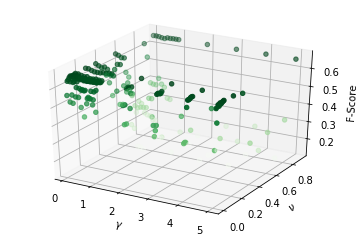

In [875]:
ax = plt.axes(projection='3d')

zdata = z2_user
xdata = x_user
ydata = y_user

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel("F-Score")


ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("user_F_Score.png")

In [ ]:
for angle in range(0, 360,10):
    ax = plt.axes(projection='3d')
    ax.view_init(30, angle)
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
    plt.pause(.001)

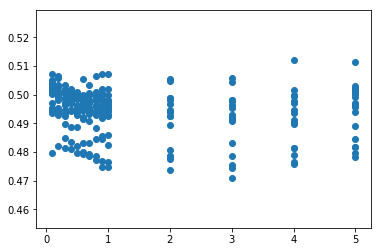

In [878]:
zdata_2d = z1_user
xdata_2d = x_user
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

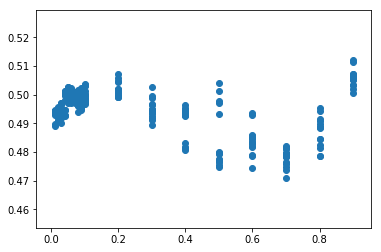

In [879]:
zdata_2d = z1_user
ydata_2d = y_user
plt.scatter(x=ydata_2d, y=zdata_2d, cmap='Greens')

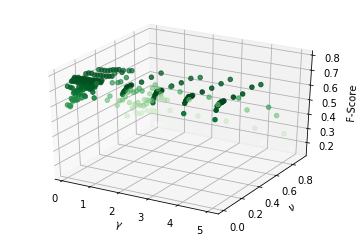

In [880]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = z2_message
xdata = x_message
ydata = y_message

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel("F-Score")

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("message_F_Score.png")

In [ ]:
for angle in range(0, 360,10):
    ax = plt.axes(projection='3d')
    ax.view_init(30, angle)
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
#     plt.draw()
    plt.pause(.001)

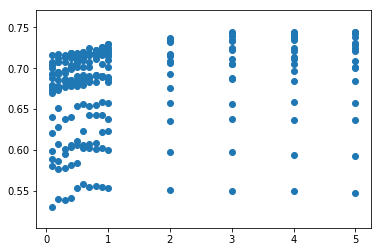

In [830]:
zdata_2d = z1_message
xdata_2d = x_message
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

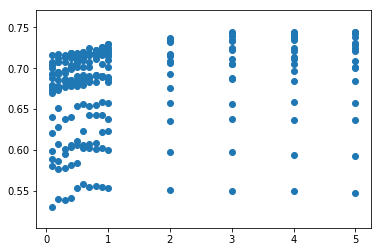

In [833]:
zdata_2d = z1_message
ydata_2d = y_message
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

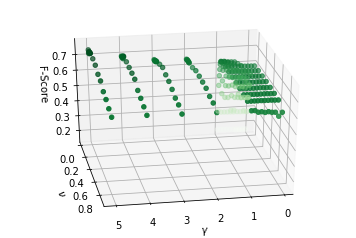

In [883]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = z2_linguistic
xdata = x_linguistic
ydata = y_linguistic

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel("F-Score")

ax.view_init(30, 80)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("linguistic_F_Score.png")

In [ ]:
for angle in range(0, 360,10):
    ax = plt.axes(projection='3d')
    ax.view_init(30, angle)
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
    plt.pause(.001)

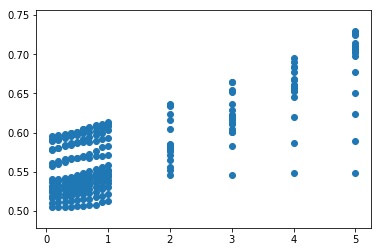

In [834]:
zdata_2d = z1_linguistic
xdata_2d = x_linguistic
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

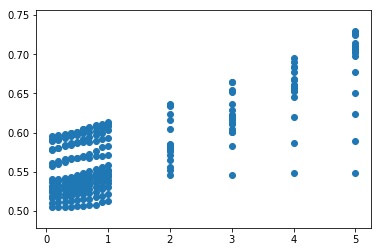

In [835]:
zdata_2d = z1_linguistic
ydata_2d = y_linguistic
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

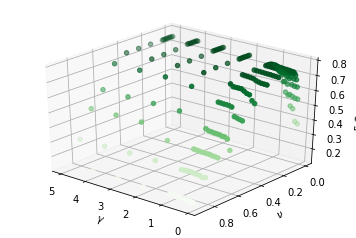

In [885]:
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata = z2
xdata = x
ydata = y

ax.set_xlabel(r'$\gamma$')
ax.set_ylabel(r'$\nu$')
ax.set_zlabel("F-Score")

ax.view_init(30, 130)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
plt.savefig("total_F_Score.png")

In [ ]:
for angle in range(0, 360,10):
    ax = plt.axes(projection='3d')
    ax.view_init(30, angle)
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
    plt.pause(.001)

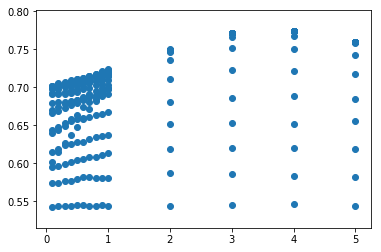

In [838]:
zdata_2d = z1
ydata_2d = y
plt.scatter(x=xdata_2d, y=zdata_2d, cmap='Greens')

In [ ]:
for angle in range(0, 360,10):
    ax = plt.axes(projection='3d')
    ax.view_init(0, angle)
    ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
    plt.pause(.001)

In [754]:
evaluation = {"Linguistic":{"F-Measure":z2_linguistic[0], "Accuracy":z1_linguistic[0]},\
              "Message":{"F-Measure":z2_message[0], "Accuracy":z1_message[0]}, \
              "User":{"F-Measure":z2_user[0], "Accuracy":z1_user[0]},\
              "Total":{"F-Measure":z2[0], "Accuracy":z1[0]}}

In [803]:
df_evaluation = pd.DataFrame.from_dict(evaluation, orient="columns")

In [804]:
df_evaluation.rename(columns={"F-Measure":"F-score", "Accuracy":"Accuracy"}, index={"Total":" Total"}, inplace=True)

In [805]:
df_evaluation

,Linguistic,Message,Total,User
Accuracy,0.729483,0.745048,0.774376,0.512220
F-Measure,0.756963,0.782371,0.770465,0.657782


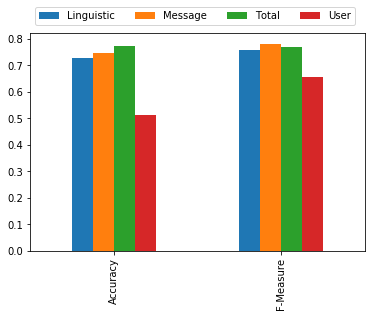

In [808]:
df_evaluation.plot(kind="bar",  )
plt.legend(loc='center left', bbox_to_anchor=(0, 1.08), ncol=4)
plt.savefig("eval.png",bbox_inches='tight')

In [759]:
roc = [(v["TPR"], v["FPR"]) for k,v in results.items()]
roc_linguistic = [(v["TPR"], v["FPR"]) for k,v in results_linguistic.items()]
roc_message = [(v["TPR"], v["FPR"]) for k,v in results_message.items()]
roc_user = [(v["TPR"], v["FPR"]) for k,v in results_user.items()]

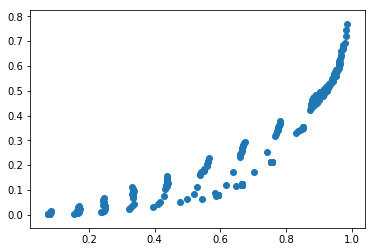

In [760]:
plt.scatter(x=[tp[0] for tp in roc], y=[tp[1] for tp in roc])

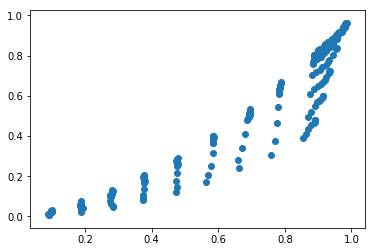

In [761]:
plt.scatter(x=[tp[0] for tp in roc_linguistic], y=[tp[1] for tp in roc_linguistic])

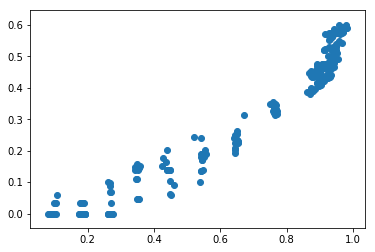

In [762]:
plt.scatter(x=[tp[0] for tp in roc_message], y=[tp[1] for tp in roc_message])

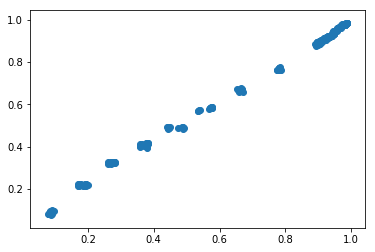

In [763]:
plt.scatter(x=[tp[0] for tp in roc_user], y=[tp[1] for tp in roc_user])